In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from wordcloud import WordCloud

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D,Concatenate,Flatten,Add,Dropout,GRU,Bidirectional
import random 
import datetime
from nltk.translate.bleu_score import sentence_bleu
from math import log
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/Radiologists Report Mcv1.xlsx')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient ID         505 non-null    int64 
 1   Clinician's Notes  505 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.0+ KB


In [ ]:
df.shape

(505, 2)

In [ ]:
df[df['Patient ID']==3]["Clinician's Notes"]

2    Features of muscle spasm noted. small central ...
Name: Clinician's Notes, dtype: object

In [ ]:
print(df.iloc[2]["Clinician's Notes"])

Features of muscle spasm noted. small central disc protrusion noted at L5-S1 level abutting the thecal sac. no significant thecal sac or nerve root compression noted.


In [ ]:

# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/MRI_Data.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_FS_COR_384_3MM_BILATERAL_0003/T2_TSE_FS_C_0521_020.ima 2018-06-23 14:15:46       207296
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/ 2018-06-25 01:14:26            0
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_001.ima 2018-06-23 14:15:46       207548
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_002.ima 2018-06-23 14:15:46       207560
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_003.ima 2018-06-23 14:15:46       207552
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_004.ima 2018-06-23 14:15:48       207556
01_MRI_Data/0521/PELVIS_PELVIS_20160224_151025_070000/T2_TSE_SAG_256_0007/T2_TSE_SAG__0521_005.ima 2018-06-23 14:15:48       207554
01_MRI_Data/0521/PELVIS_PELVIS_2

In [ ]:
!rm -rf /content/01_MRI_Data/0179
!rm -rf /content/01_MRI_Data/0363
!rm -rf /content/01_MRI_Data/0265
!rm -rf /content/01_MRI_Data/0350
!rm -rf /content/01_MRI_Data/0486
!rm -rf /content/01_MRI_Data/0488
!rm -rf /content/01_MRI_Data/0221
!rm -rf /content/01_MRI_Data/0314
!rm -rf /content/01_MRI_Data/0156
!rm -rf /content/01_MRI_Data/0368

!cp -r /content/01_MRI_Data/0113/L-SPINE_LSS_20160123_144107_038000/POSDISP_[4]_T2_TSE_TRA_384_5001
!cp -r /content/01_MRI_Data/0113/L-SPINE_LSS_20160123_144107_038000/LOCALIZER_0001 

In [ ]:
!pip install pyDicom

     |████████████████████████████████| 1.9MB 8.3MB/s 


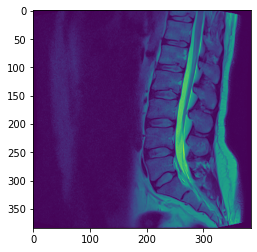

In [ ]:
import pydicom
import matplotlib.pyplot as plt

filePath = '/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LIBRARIES_20160608_132349_824000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0005_003.ima'
img = pydicom.read_file(filePath)

plt.imshow(img.pixel_array)
plt.show()

16


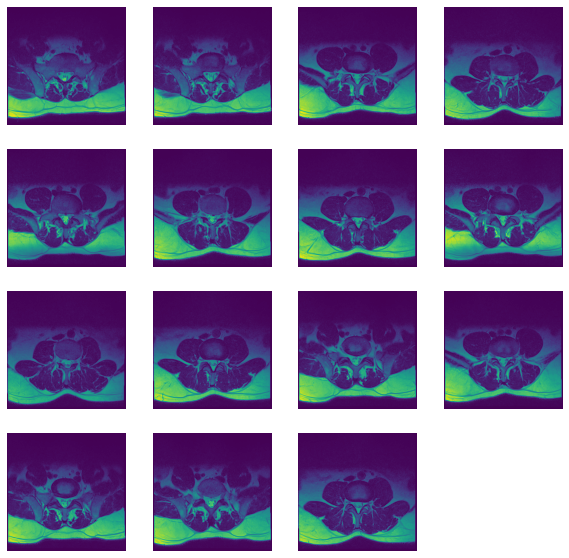

In [ ]:
import glob
path=f'/content/01_MRI_Data/0005/L-SPINE_CLINICAL_LIBRARIES_20160608_132349_824000/T2_TSE_TRA_384_0004/*.ima'
i=1
fig = plt.figure(figsize=(10, 10))
#fig.add_subplot(2, , 1)
for file in glob.glob(path):
  img = pydicom.read_file(file)
  fig.add_subplot(4, 4, i)
  #print(i)
  i+=1
  plt.imshow(img.pixel_array)
  plt.axis('off')
print(i)
plt.show()

In [ ]:
from skimage.transform import resize
from collections import defaultdict
import itertools
from collections import Counter
from tqdm import tqdm

In [ ]:
import os
dirs= os.walk("/content/01_MRI_Data").__next__()[1]
print(len(dirs))
dirs.sort()

505


In [ ]:
from collections import defaultdict
#path='/content/01_MRI_Data/*/*/*/*.ima'
import glob
patient=[]
image_per_person = defaultdict(list)
for i in range(len(dirs)):
  patientid=dirs[i]
  patient.append(patientid)
  path=f'/content/01_MRI_Data/{patientid}/*/*/*.ima'
  no_of_images=0
  for file in glob.glob(path):
    patientid=int(patientid)
    image_per_person[patientid].append(file)
    #print(image_per_person[patientid])
    #img = pydicom.read_file(file)
    #X=img.pixel_array
  #print("Image",img.pixel_array)
    #X=np.asarray(X)
    #X = preprocess_input(X)
    #X = resize(X, (224,224,3))
    #X = np.expand_dims(X, axis=0)
    #X = np.asarray(X)
    no_of_images=no_of_images+1
  #print("X",X.shape)
    #print("FileName",file)
    #print(X.shape)
  print(f"Count of Images for Patient {patientid}",no_of_images) 

Count of Images for Patient 1 65
Count of Images for Patient 2 72
Count of Images for Patient 3 71
Count of Images for Patient 4 70
Count of Images for Patient 5 71
Count of Images for Patient 6 79
Count of Images for Patient 7 98
Count of Images for Patient 8 73
Count of Images for Patient 9 64
Count of Images for Patient 10 71
Count of Images for Patient 11 116
Count of Images for Patient 12 70
Count of Images for Patient 13 72
Count of Images for Patient 14 84
Count of Images for Patient 15 81
Count of Images for Patient 16 71
Count of Images for Patient 17 128
Count of Images for Patient 19 81
Count of Images for Patient 20 222
Count of Images for Patient 21 74
Count of Images for Patient 22 83
Count of Images for Patient 23 176
Count of Images for Patient 24 70
Count of Images for Patient 25 71
Count of Images for Patient 26 71
Count of Images for Patient 27 182
Count of Images for Patient 29 95
Count of Images for Patient 30 73
Count of Images for Patient 31 107
Count of Images f

In [ ]:
image_per_person.items()

dict_items([(1, ['/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_001.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_003.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_002.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_003.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_005.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_001.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_006.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_002.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/LOCALIZER_0001/LOCALIZER_0_0001_008.im

In [ ]:
import operator

In [ ]:

def create_data(image_per_person):
    # new dataset
    #patientid, image1, image2,image3,image4,image5, report = [],[],[],[],[],[],[]
    patientid,extra,images_patient_T1_TSE_TRA,images_patient_T2_TSE_TRA,images_patient_T1_TSE_SAG,images_patient_T2_TSE_SAG, POSDISP_,LOCALIZER_,report = [],[],[],[],[],[],[],[],[]
    images_per_patient = defaultdict(list)
    patientid,images_patient, report = [],[],[]
    i=0
    for pid, imgs in image_per_person.items():
      #print("pid",pid)
      #print("imgs",imgs)
         #contains pid and the images associated with that pid
      patientid.append(pid)
      
      images1,images2,images3,images4,images5,images6,images7=[],[],[],[],[],[],[]
      #print(f"i",len(imgs))
      #j=0
      for img in imgs:
        #print(img)
        

        if img.split('/')[5].startswith('T1_TSE_TRA'):
          images1.append(img)
        elif img.split('/')[5].startswith('T2_TSE_TRA'):
          #print(img.find('T2_TSE_TRA'))
          images2.append(img)
        elif img.split('/')[5].startswith('T1_TSE_SAG'):
          images3.append(img)
        elif img.split('/')[5].startswith('T2_TSE_SAG'):
          images4.append(img)
        elif img.split('/')[5].startswith('POSDISP'):
          images5.append(img)
          #j+=1
        elif img.split('/')[5].startswith('LOCALIZER'):
          images6.append(img)
        else:
          images7.append(img)  

      report.append(df.iloc[i]["Clinician's Notes"])
      i+=1
      #print(f"{i}",j)
      
      #images_patient.append(images)      
      images_patient_T1_TSE_TRA.append(images1)
      images_patient_T2_TSE_TRA.append(images2)
      images_patient_T1_TSE_SAG.append(images3)
      images_patient_T2_TSE_SAG.append(images4)
      POSDISP_.append(images5)
      LOCALIZER_.append(images6)
      extra.append(images7)
      
      #images_per_patient=images_per_patient[pid].append(images)
      #print(images_per_patient[pid])
      #print((images))
    L=[]
    data = pd.DataFrame()
    print(POSDISP_)
    final_data=pd.DataFrame()
    data['Patient_id'] = patientid
    data['Notes'] = report
    data['T1_TSE_TRA']= images_patient_T1_TSE_TRA
    data['T2_TSE_TRA']= images_patient_T2_TSE_TRA
    data['T1_TSE_SAG']= images_patient_T1_TSE_SAG
    data['T2_TSE_SAG']= images_patient_T1_TSE_SAG
    data['POSDISP_']= POSDISP_
    data['LOCALIZER_']= LOCALIZER_
    data['EXTRA']=extra
    print(data['POSDISP_']) 
    
    return data

In [ ]:
df["Clinician's Notes"][df["Patient ID"]==2]

1    No evidence of disc herniation. No significant...
Name: Clinician's Notes, dtype: object

In [ ]:
df_image_notes = create_data(image_per_person)

[['/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_001.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_003.ima', '/content/01_MRI_Data/0001/L-SPINE_LSS_20160309_091629_240000/POSDISP_[4]_T2_TSE_TRA_384_5001/POSDISP_[4]_0001_002.ima'], ['/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LIBRARIES_20160621_112938_873000/POSDISP_[3]_T1_TSE_SAG_320_5002/POSDISP_[3]_0002_002.ima', '/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LIBRARIES_20160621_112938_873000/POSDISP_[3]_T1_TSE_SAG_320_5002/POSDISP_[3]_0002_001.ima', '/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LIBRARIES_20160621_112938_873000/POSDISP_[5]_T1_TSE_TRA_5001/POSDISP_[5]_0002_001.ima', '/content/01_MRI_Data/0002/L-SPINE_CLINICAL_LIBRARIES_20160621_112938_873000/POSDISP_[5]_T1_TSE_TRA_5001/POSDISP_[5]_0002_002.ima'], ['/content/01_MRI_Data/0003/L-SPINE_LSS_20160411_134646_314000/POSDISP_[4]_T2_TSE_TRA_384_5001/P

In [ ]:
df_image_notes.head()

Patient_id  ... EXTRA
0           1  ...    []
1           2  ...    []
2           3  ...    []
3           4  ...    []
4           5  ...    []

[5 rows x 9 columns]

In [ ]:
df_image_notes.shape

(505, 9)

In [ ]:
df_image_notes['LOCALIZER_'][326]

['/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_005.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_007.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_004.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_001.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_006.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_003.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_008.ima',
 '/content/01_MRI_Data/0370/L-SPINE_LSS_20160409_144610_837000/LOCALIZER_0001/LOCALIZER_0_0370_002.ima']

In [ ]:
df_image_notes.iloc[0]['Notes']

'L4-L5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. Evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus.'

In [ ]:
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import preprocess_input
chex = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3))
X = chex.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chex.input, outputs=X)
#model.load_weights('/content/drive/MyDrive/Capstone Project/Problem Statement Finalization/Spinal MRI - Disc abnormality detection/Datasets/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')
chexnet = Model(inputs = model.input, outputs = model.layers[-2].output)
chexnet.load_weights('/content/drive/MyDrive/Capstone Project/pickle_files/model_chexnet_Bi_40_second.h5')

In [ ]:
chexnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
len(chexnet.layers)

427

In [ ]:
for layer in chexnet.layers[350:]:
  layer.trainable = True

In [ ]:
for layer in chexnet.layers[:350]:
  layer.trainable = False

In [ ]:
chexnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def load_image_resize(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    #print("monochrome",dicom.PhotometricInterpretation)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME2":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint16)
    data = preprocess_input(data)
    data = resize(data, (224,224,3))
    #plt.imshow(data,cmap=plt.cm.gray)
    data = np.expand_dims(data,axis= 0)
    data = np.asarray(data)
    # plt.imshow(data,cmap=plt.cm.gray)

    return data

In [ ]:
range(df_image_notes.shape[0])

range(0, 505)

In [ ]:
for i in range(df_image_notes.shape[0]):
  if len(df_image_notes['T1_TSE_TRA'][i])==0 :
    print(i)


In [ ]:
len(df_image_notes['POSDISP_'][311])

11

In [ ]:
df_image_notes['Patient_id'][187]

208

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [ ]:

input_=np.zeros(shape=(224,224,3))
for j in range(len(df_image_notes['T1_TSE_TRA'][5])):
  image_shaped=load_image_resize(df_image_notes['T1_TSE_TRA'][5][j])
  #print(image_shaped)
  input_ =np.add(input_,image_shaped)
FM_T1_TSE_TRA1=(input_/len(df_image_notes['T1_TSE_TRA'][5]))

In [ ]:
FM_T1_TSE_TRA1.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


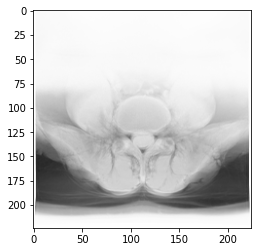

In [ ]:
plt.imshow(FM_T1_TSE_TRA1[0])

In [ ]:

input_=np.zeros(shape=(224,224,3))
for j in range(len(df_image_notes['T1_TSE_TRA'][5])):
  image_shaped=load_image_resize(df_image_notes['T1_TSE_TRA'][5][j])
  #print(image_shaped)
  input_ =np.add(input_,image_shaped)
  
FM_T1_TSE_TRA2=(input_/len(df_image_notes['T1_TSE_TRA'][5]))

In [ ]:
FM_T1_TSE_TRA=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['T1_TSE_TRA'][i])):
  image_shaped=load_image_resize(df_image_notes['T1_TSE_TRA'][i][0])
    #print(image_shaped)
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  #FM_T1_TSE_TRA.append(input_/len(df_image_notes['T1_TSE_TRA'][i]))
 
  FM_T1_TSE_TRA.append(input_)

In [ ]:
  scaler = StandardScaler()
  FM_T1_TSE_TRA = scaler.fit_transform(FM_T1_TSE_TRA.reshape(-1, FM_T1_TSE_TRA.shape[-1])).reshape(FM_T1_TSE_TRA.shape) 

In [ ]:
FM_T1_TSE_TRA[1].shape

(1, 224, 224, 3)

In [ ]:
FM_T2_TSE_TRA=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['T2_TSE_TRA'][i])):
  image_shaped=load_image_resize(df_image_notes['T2_TSE_TRA'][i][0])
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T2_TSE_TRA.append(input_)

In [ ]:
FM_T2_TSE_TRA = np.array(FM_T2_TSE_TRA)
scaler = StandardScaler()
FM_T2_TSE_TRA = scaler.fit_transform(FM_T2_TSE_TRA.reshape(-1, FM_T2_TSE_TRA.shape[-1])).reshape(FM_T2_TSE_TRA.shape) 

In [ ]:
FM_T1_TSE_SAG = []
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['T1_TSE_SAG'][i])):
  image_shaped=load_image_resize(df_image_notes['T1_TSE_SAG'][i][0])
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T1_TSE_SAG.append(input_)

In [ ]:
FM_T1_TSE_SAG = np.array(FM_T1_TSE_SAG)
scaler = StandardScaler()
FM_T1_TSE_SAG = scaler.fit_transform(FM_T1_TSE_SAG.reshape(-1, FM_T1_TSE_SAG.shape[-1])).reshape(FM_T1_TSE_SAG.shape) 

In [ ]:
FM_T2_TSE_SAG = []
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['T2_TSE_SAG'][i])):
  image_shaped=load_image_resize(df_image_notes['T2_TSE_SAG'][i][0])
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)
  FM_T2_TSE_SAG.append(input_)

In [ ]:
FM_T2_TSE_SAG = np.array(FM_T2_TSE_SAG)
scaler = StandardScaler()
FM_T2_TSE_SAG = scaler.fit_transform(FM_T2_TSE_SAG.reshape(-1, FM_T2_TSE_SAG.shape[-1])).reshape(FM_T2_TSE_SAG.shape) 

In [ ]:
FM_POSDISP_=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['POSDISP_'][i])):
  image_shaped=load_image_resize(df_image_notes['POSDISP_'][i][0])
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  FM_POSDISP_.append(input_)

In [ ]:
FM_POSDISP_ = np.array(FM_POSDISP_)
scaler = StandardScaler()
FM_POSDISP_ = scaler.fit_transform(FM_POSDISP_.reshape(-1, FM_POSDISP_.shape[-1])).reshape(FM_POSDISP_.shape) 

In [ ]:
FM_LOCALIZER_=[]
for i in range(df_image_notes.shape[0]):
  input_=np.zeros(shape=(224,224,3))
  #for j in range(len(df_image_notes['LOCALIZER_'][i])):
  image_shaped=load_image_resize(df_image_notes['LOCALIZER_'][i][0])
  input_ =np.add(input_,image_shaped)
  #print(f"{i} ",input_.shape)  
  FM_LOCALIZER_.append(input_/len(df_image_notes['LOCALIZER_'][i]))

In [ ]:
FM_LOCALIZER_ = np.array(FM_LOCALIZER_)
scaler = StandardScaler()
FM_LOCALIZER_ = scaler.fit_transform(FM_LOCALIZER_.reshape(-1, FM_LOCALIZER_.shape[-1])).reshape(FM_LOCALIZER_.shape) 

In [ ]:
FM_T1_TSE_TRA.shape

(505, 224, 224, 3)

Xnet_features_attention = image_features(df_image_notes)

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T1_TSE_TRA.pickle','rb') # contains the features from chexNet
FM_T1_TSE_TRA = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T2_TSE_TRA.pickle','rb') # contains the features from chexNet
FM_T2_TSE_TRA = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T1_TSE_SAG.pickle','rb') # contains the features from chexNet
FM_T1_TSE_SAG = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_T2_TSE_SAG.pickle','rb') # contains the features from chexNet
FM_T2_TSE_SAG = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_LOCALIZER_.pickle','rb') # contains the features from chexNet
FM_LOCALIZER_ = pickle.load(f)
f.close()

In [ ]:

f = open('/content/drive/MyDrive/Capstone Project/pickle_files/FM_POSDISP_.pickle','rb') # contains the features from chexNet
FM_POSDISP_ = pickle.load(f)
f.close()

In [ ]:
FM_POSDISP_.shape

(505, 1, 224, 224, 3)

**Text Cleaning** 

In [ ]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        line=str(line)
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [ ]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    #new_text = decontractions(new_text)
    #new_text = rem_punctuations(new_text)
    #new_text = rem_numbers(new_text)
    #new_text = words_filter(new_text)
    #new_text = multiple_fullstops(new_text)
    #new_text = fullstops(new_text)
    #new_text = multiple_spaces(new_text)
    #new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [ ]:
train=df_image_notes

In [ ]:
train['Notes'] = text_preprocessing(train['Notes'])

In [ ]:
for i in range(train.shape[0]):
  if(len(train.iloc[i]['T1_TSE_TRA'])==0 or len(train.iloc[i]['T2_TSE_TRA'])==0 or
     len(train.iloc[i]['T2_TSE_SAG'])==0 or len(train.iloc[i]['T1_TSE_SAG'])==0
     or len(train.iloc[i]['POSDISP_'])==0 or len(train.iloc[i]['LOCALIZER_'])==0
     ):
    print(i)


In [ ]:
train.columns

Index(['Patient_id', 'Notes', 'T1_TSE_TRA', 'T2_TSE_TRA', 'T1_TSE_SAG',
       'T2_TSE_SAG', 'POSDISP_', 'LOCALIZER_', 'EXTRA'],
      dtype='object')

In [ ]:
train.isnull().sum()

Patient_id    0
Notes         0
T1_TSE_TRA    0
T2_TSE_TRA    0
T1_TSE_SAG    0
T2_TSE_SAG    0
POSDISP_      0
LOCALIZER_    0
EXTRA         0
dtype: int64

In [ ]:
train.head()

Patient_id  ... EXTRA
0           1  ...    []
1           2  ...    []
2           3  ...    []
3           4  ...    []
4           5  ...    []

[5 rows x 9 columns]

In [ ]:
train.shape

(505, 9)

In [ ]:
l = [len(e.split()) for e in train['Notes'].values] 

In [ ]:
max(l)

135

Text(0, 0.5, 'Number of words')

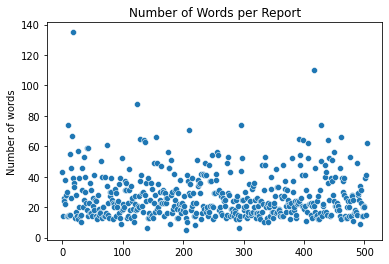

In [ ]:
plt.title('Number of Words per Report')
sns.scatterplot(range(train.shape[0]), l)
plt.ylabel('Number of words')

In [ ]:

l = []
for i in train['Notes'].values:
    l.extend(i.split())

In [ ]:
w = WordCloud(height=1500, width=1500).generate(str(l))

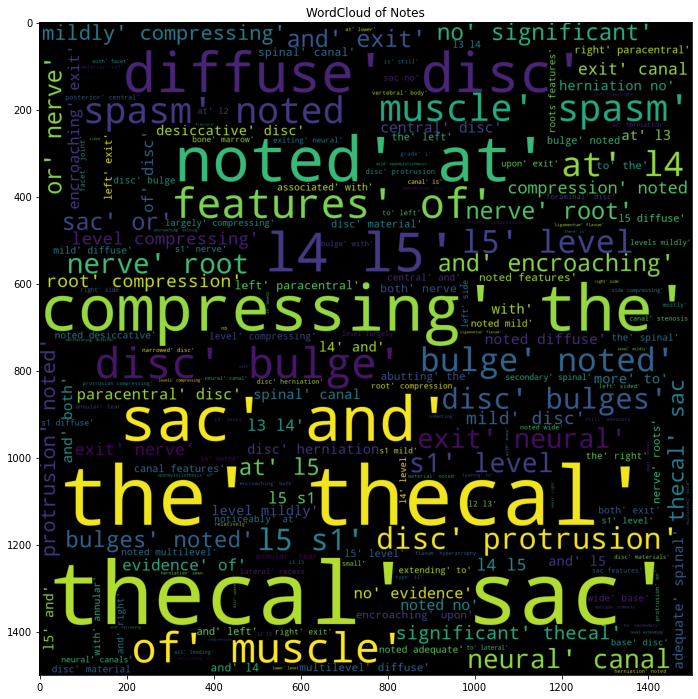

In [ ]:
plt.figure(figsize=(12,12))
plt.title('WordCloud of Notes')
plt.imshow(w)

In [ ]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [ ]:
train.iloc[0]['Notes']

'l4-l5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus.'

In [ ]:
train['Notes'] = train['Notes'].apply(lambda x : remodelling(x))

In [ ]:
train.iloc[0]['Notes']

'startseq l4-l5: degenerative annular disc bulge is noted more to the left side compressing the thecal sac, compressing left nerve root and narrowing right neural foramen. evidence of hyperintense signal within the annulus fibrosus at left paramedian/posterolateral area which probably represents a torn annulus. endseq'

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(train['Patient_id'], train['Notes'], test_size=0.1, random_state=42)

In [ ]:
len(train.Notes.values[:500])

500

In [ ]:
X_train_img, X_cv_img, y_train_rep, y_cv_rep = train_test_split(train.index[:500], train.Notes.values[:500],
                                                                test_size = 0.1, random_state=97) # input only 50 patients

In [ ]:
print(len(X_cv_img),len(X_train_img))

50 450


In [ ]:
y_train_rep[11]

'startseq l4-l5: diffuse disc bulge compressing the thecal sac and exit neural canals. endseq'

In [ ]:
max_capt_len = 135
pad_size = max_capt_len

In [ ]:
decoder_t = Tokenizer(filters='!"#$%&()*+,/:;<=>?@[\\]^_`{|}~\t\n')
decoder_t.fit_on_texts(train.Notes.values)

In [ ]:
len(decoder_t.word_index.keys())

695

In [ ]:
print(decoder_t.word_index)

{'disc': 1, 'thecal': 2, 'the': 3, 'and': 4, 'noted': 5, 'startseq': 6, 'endseq': 7, 'sac': 8, 'at': 9, 'compressing': 10, 'noted.': 11, 'of': 12, 'l4-l5': 13, 'exit': 14, 'nerve': 15, 'level': 16, 'diffuse': 17, 'bulge': 18, 'muscle': 19, 'features': 20, 'spasm': 21, 'l5-s1': 22, 'no': 23, 'with': 24, 'protrusion': 25, 'left': 26, 'neural': 27, 'bulges': 28, 'mild': 29, 'or': 30, 'encroaching': 31, 'right': 32, 'root': 33, 'canal.': 34, 'canals.': 35, 'compression': 36, 'significant': 37, 'spinal': 38, 'to': 39, 'l3-l4': 40, 'mildly': 41, 'central': 42, 'sac.': 43, 'roots.': 44, 'paracentral': 45, 'both': 46, 'evidence': 47, 'canal': 48, 'level.': 49, 'multilevel': 50, 'levels': 51, 'adequate': 52, 'is': 53, 'more': 54, 'herniation.': 55, 'roots': 56, 'desiccative': 57, 'abutting': 58, 'small': 59, 'upon': 60, 'root.': 61, 'canals': 62, 'annular': 63, 'side': 64, 'material': 65, 'wide': 66, 'posterior': 67, 'l2-l3': 68, 'base': 69, 'herniation': 70, 'associated': 71, 's1': 72, 'bone':

In [ ]:
y_train_rep_tok =decoder_t.texts_to_sequences(y_train_rep)
y_cv_rep_tok =decoder_t.texts_to_sequences(y_cv_rep)

In [ ]:
train_rep_padded = pad_sequences(y_train_rep_tok, maxlen=135, padding='post')
cv_rep_padded=pad_sequences(y_cv_rep_tok,maxlen=135,padding='post')

In [ ]:
train_rep_padded

array([[  6,  22,  17, ...,   0,   0,   0],
       [  6,  20,  12, ...,   0,   0,   0],
       [  6,  13, 158, ...,   0,   0,   0],
       ...,
       [  6,  40,  29, ...,   0,   0,   0],
       [  6,  23,  47, ...,   0,   0,   0],
       [  6,  17,   1, ...,   0,   0,   0]], dtype=int32)

In [ ]:
int_to_word_decoder = dict((i,c) for c, i in decoder_t.word_index.items())

In [ ]:
int_to_word_decoder[15]

'nerve'

In [ ]:
def build_decoder_output_data(decoder_input_data):

    #Initialize array to be same size as caption array
    decoder_target_data = np.zeros((decoder_input_data.shape[0], decoder_input_data.shape[1]))
    
    #Shift Target output by one word i.e REMOVE <start> tag
    for i in range(decoder_input_data.shape[0]):
        for j in range(1,decoder_input_data.shape[1]):
            decoder_target_data[i][j-1] = decoder_input_data[i][j]

    
    #Initialize one hot encoding array
    decoder_target_one_hot = np.zeros((decoder_input_data.shape[0], #number of sentences
                                    decoder_input_data.shape[1], #Number of words in each sentence
                                    len(decoder_t.word_index)+1)) #Vocab size + 1
    

    
    #Build one hot encoded array
    for i in range(decoder_target_data.shape[0]):
        for j in range(decoder_target_data.shape[1]):
            decoder_target_one_hot[i][j] = tf.keras.utils.to_categorical(decoder_target_data[i][j],
                                                                        num_classes=len(decoder_t.word_index)+1)
    
    return decoder_target_one_hot

In [ ]:
train_labels = build_decoder_output_data(train_rep_padded)
cv_labels = build_decoder_output_data(cv_rep_padded) 

In [ ]:
train_labels.shape

(450, 135, 696)

In [ ]:
cv_labels.shape

(50, 135, 696)

In [ ]:
vocab_size = len(decoder_t.word_index.keys()) + 1

In [ ]:
vocab_size

696

In [ ]:
all_embeddings = np.load('/content/drive/MyDrive/Capstone Project/pickle_files/embeddings696.npy')

In [ ]:
all_embeddings.shape

(696, 200)

In [ ]:
index=train.index

In [ ]:
index

RangeIndex(start=0, stop=505, step=1)

In [ ]:
input1 = Input(shape=(224,224,3), name='Image_1')
chexnet_model1=chexnet(input1)
input2 = Input(shape=(224,224,3), name='Image_2')
chexnet_model2=chexnet(input2)
input3 = Input(shape=(224,224,3), name='Image_3')
chexnet_model3=chexnet(input3)
input4 = Input(shape=(224,224,3), name='Image_4')
chexnet_model4=chexnet(input4)
input5 = Input(shape=(224,224,3), name='Image_5')
chexnet_model5=chexnet(input5)
input6 = Input(shape=(224,224,3), name='Image_6')
chexnet_model6=chexnet(input6)

add_six_chexnet_output=tf.keras.layers.Add()([chexnet_model1,chexnet_model2,chexnet_model3,chexnet_model4,chexnet_model5,chexnet_model6])

In [ ]:
add_six_chexnet_output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'add_3')>

In [ ]:
chexnet.output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'relu')>

In [ ]:
#Get RestNet50 output
x1 = add_six_chexnet_output

#Optional - try to reduce depth of Resnet50 output by using a Convolutional layer
#This can help reduce weights and hence reduce overfitting
#conv_x1 = tf.keras.layers.Conv2D(100, (1,1), activation='relu')(x1)

#Convert it to 2D from 3D i.e 7,7,1024 to 49, 1024
x2 = tf.keras.layers.Reshape((49, 1024))(x1)

In [ ]:
x2

<KerasTensor: shape=(None, 49, 1024) dtype=float32 (created by layer 'reshape_4')>

In [ ]:
memory_size=256

In [ ]:
encoder_lstm = tf.keras.layers.LSTM(memory_size, return_state=True, return_sequences=True)

In [ ]:
encoder_all_h_states, state_h, state_c = encoder_lstm(x2)

In [ ]:
#Build a list to feed Decoder
encoder_states = [state_h, state_c]

In [ ]:
encoder_all_h_states

<KerasTensor: shape=(None, 49, 256) dtype=float32 (created by layer 'lstm_6')>

In [ ]:
state_h

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_6')>

In [ ]:
max_decoder_seq_length=135

In [ ]:
#build decoder
decoder_inputs = tf.keras.layers.Input(shape=(max_decoder_seq_length,))

#embedding layer
decoder_embedding = tf.keras.layers.Embedding( vocab_size,  200,
                     weights=[all_embeddings], trainable=False,name="Embedding_layer")

decoder_embedding_output = decoder_embedding(decoder_inputs)

decoder_rnn = (tf.keras.layers.LSTM(memory_size, return_sequences=True, return_state=True))

decoder_all_h_states, d_state_h, d_state_c = decoder_rnn(decoder_embedding_output,
                                                       initial_state=encoder_states)


In [ ]:
decoder_all_h_states

<KerasTensor: shape=(None, 135, 256) dtype=float32 (created by layer 'lstm_7')>

In [ ]:
#Attention matrix
score = tf.keras.layers.dot([decoder_all_h_states, encoder_all_h_states], axes=2)
attention_matrix = tf.keras.layers.Activation('softmax')(score)

In [ ]:
score

<KerasTensor: shape=(None, 135, 49) dtype=float32 (created by layer 'dot_8')>

In [ ]:
attention_matrix

<KerasTensor: shape=(None, 135, 49) dtype=float32 (created by layer 'activation_4')>

In [ ]:
context_vector = tf.keras.layers.dot([attention_matrix, encoder_all_h_states], axes=[2,1])

In [ ]:
context_vector

<KerasTensor: shape=(None, 135, 256) dtype=float32 (created by layer 'dot_9')>

In [ ]:
context_decoder_hidden = tf.keras.layers.concatenate([context_vector, 
                                                      decoder_all_h_states])

In [ ]:
context_decoder_hidden

<KerasTensor: shape=(None, 135, 512) dtype=float32 (created by layer 'concatenate_4')>

In [ ]:
attention_dense_layer = tf.keras.layers.Dense(128, use_bias=False, activation='relu')
attention_vector = attention_dense_layer(context_decoder_hidden)

In [ ]:
attention_vector

<KerasTensor: shape=(None, 135, 128) dtype=float32 (created by layer 'dense_6')>

In [ ]:
#Output layer
decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

#With attention input will be attention_vector and not decoder_all_h_states
decoder_outputs = decoder_dense(attention_vector)

In [ ]:
decoder_outputs

<KerasTensor: shape=(None, 135, 696) dtype=float32 (created by layer 'dense_7')>

In [ ]:
model = Model(inputs = [input1, input2,input3,input4,input5,input6,decoder_inputs], outputs = decoder_outputs)
#model = Model(inputs = [chexnet.input,decoder_inputs], outputs = decoder_outputs)


In [ ]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Image_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
___________________________________________________________________________________________

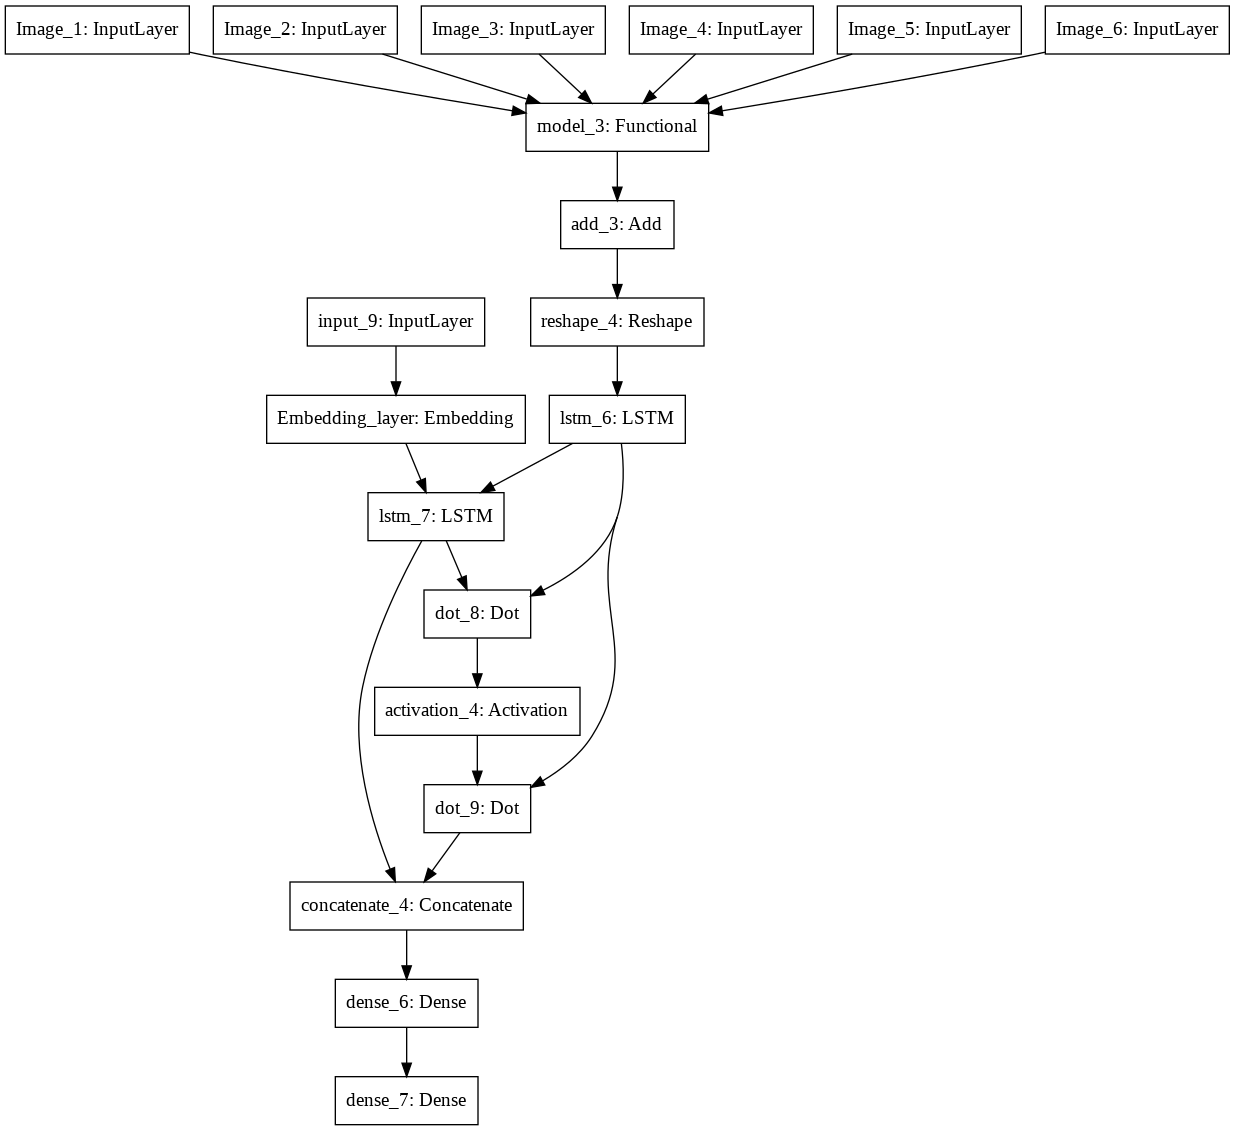

In [ ]:
    tf.keras.utils.plot_model(
        model, to_file='model1.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
    )
    

In [ ]:
import random


In [ ]:
random.sample(list(X_train_img),5)

[379, 12, 401, 382, 125]

In [ ]:
np.random.randint(0, len(X_train_img), 5)

array([361, 314, 398, 244, 114])

In [ ]:
X_train_img[1]

111

In [ ]:
img_size=224

In [ ]:
def batch_generator(image1,image2,image3,image4,image5,image6,image_index, decoder_input, labels, batch_size=5, train_mode=True):

    while(True):

        #Batch of images
        batch_images1 = np.zeros((batch_size, img_size, img_size, 3))
        batch_images2 = np.zeros((batch_size, img_size, img_size, 3))
        batch_images3 = np.zeros((batch_size, img_size, img_size, 3))
        batch_images4 = np.zeros((batch_size, img_size, img_size, 3))
        batch_images5 = np.zeros((batch_size, img_size, img_size, 3))
        batch_images6 = np.zeros((batch_size, img_size, img_size, 3))
        

        #print(batch_images1.shape)
        #Batch of input to decoder - captions with <start> and <end> tag
        batch_decoder_input = np.zeros((batch_size, max_decoder_seq_length))
     
        #Output labels
        batch_labels = np.zeros((batch_size, max_decoder_seq_length, vocab_size))
        #print(batch_labels.shape)
        #Get indexes of images to be used as batch  random
        idxs = np.random.randint(0, len(image_index), batch_size)
        #print(idxs)
        #idxs =random.sample(list(image_index),5)
        #print(idxs)
        for i in range(batch_size):
            
            #Prepare numpy array for image
            img_num = idxs[i]
            
            batch_images1[i]=image1[image_index[img_num]]
            batch_images2[i]=image2[image_index[img_num]]
            batch_images3[i]=image3[image_index[img_num]]
            batch_images4[i]=image4[image_index[img_num]]
            batch_images5[i]=image5[image_index[img_num]]
            batch_images6[i]=image6[image_index[img_num]] 

            

            #print(input6.shape)
            #Dcoder input - caption with <start> and <end> tag
            batch_decoder_input[i] = decoder_input[img_num]
            #print(batch_decoder_input.shape)
            #Output labels - without <start> tag
            #print(labels[img_num])
            batch_labels[i] = labels[img_num]

        #We will use Resnet50 as Feature extractor for images. So normalize images as per Resnet50
        #batch_images = tf.keras.applications.resnet50.preprocess_input(batch_images)

        yield [batch_images1,batch_images2,batch_images3,batch_images4,batch_images5,batch_images6, batch_decoder_input], batch_labels

In [ ]:
x1=FM_T1_TSE_TRA[:500]
x1=np.reshape(x1, (500,224,224,3))
x2=FM_T2_TSE_TRA[:500]
x2=np.reshape(x2, (500,224,224,3))
x3=FM_T1_TSE_SAG[:500]
x3=np.reshape(x3, (500,224,224,3))
x4=FM_T2_TSE_SAG[:500]
x4=np.reshape(x4, (500,224,224,3))
x5=FM_POSDISP_[:500]
x5=np.reshape(x5, (500,224,224,3))
x6=FM_LOCALIZER_[:500]
x6=np.reshape(x6, (500,224,224,3))

In [ ]:
x1.shape

(500, 224, 224, 3)

In [ ]:
train.Notes.values[23]

'startseq l4-l5: mild broad based central disc bulge is noted indenting thecal sac. l5-s1: central disc protrusion is noted indenting thecal sac. diffuse bone marrow signal reconversion is noted. endseq'

In [ ]:
#Test batch generator
gen = batch_generator(x1, x2,x3,x4,x5,x6, X_train_img,train_rep_padded,train_labels, batch_size=5)
gen


<generator object batch_generator at 0x7f3028b429d0>

In [ ]:
X,y=next(gen)

In [ ]:
X[0].shape

(5, 224, 224, 3)

In [ ]:
X[6].shape

(5, 135)

In [ ]:
y.shape

(5, 135, 696)

In [ ]:
#X,y=next(gen)
train_generator = batch_generator(x1, x2,x3,x4,x5,x6, X_train_img,train_rep_padded,train_labels, batch_size=5)
test_generator = batch_generator(x1, x2,x3,x4,x5,x6, X_cv_img ,cv_rep_padded, cv_labels, batch_size=5)

In [ ]:
batch_size=5

In [ ]:
#Training will take time
model.fit(train_generator,
          steps_per_epoch=len(X_train_img)//batch_size,
          epochs=5,
          validation_data=test_generator,
          validation_steps=len(X_cv_img)//batch_size)

Epoch 1/5
90/90 [==============================] - 18s 201ms/step - loss: 0.4315 - accuracy: 0.9065 - val_loss: 0.4955 - val_accuracy: 0.8944
Epoch 2/5
90/90 [==============================] - 18s 198ms/step - loss: 0.3660 - accuracy: 0.9151 - val_loss: 0.3867 - val_accuracy: 0.9153
Epoch 3/5
90/90 [==============================] - 18s 198ms/step - loss: 0.3753 - accuracy: 0.9117 - val_loss: 0.3931 - val_accuracy: 0.9190
Epoch 4/5
90/90 [==============================] - 18s 200ms/step - loss: 0.3094 - accuracy: 0.9245 - val_loss: 0.4117 - val_accuracy: 0.9132
Epoch 5/5
90/90 [==============================] - 18s 199ms/step - loss: 0.3047 - accuracy: 0.9242 - val_loss: 0.3062 - val_accuracy: 0.9341


In [ ]:
input1.shape

TensorShape([None, 224, 224, 3])

In [ ]:
type(x1)

numpy.ndarray

In [ ]:
data_tensor = tf.convert_to_tensor(x1)

In [ ]:
data_tensor.shape

TensorShape([500, 224, 224, 3])

In [ ]:
encoder_model = tf.keras.models.Model(inputs=[input1, input2,input3,input4,input5,input6], #Images
                                      outputs=[encoder_all_h_states] + #Hidden states at all time steps
                                      encoder_states) #Hidden state and Cell state at last time step

In [ ]:
encoder_model.inputs

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_1')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_2')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_3')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_4')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_5')>,
 <KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'Image_6')>]

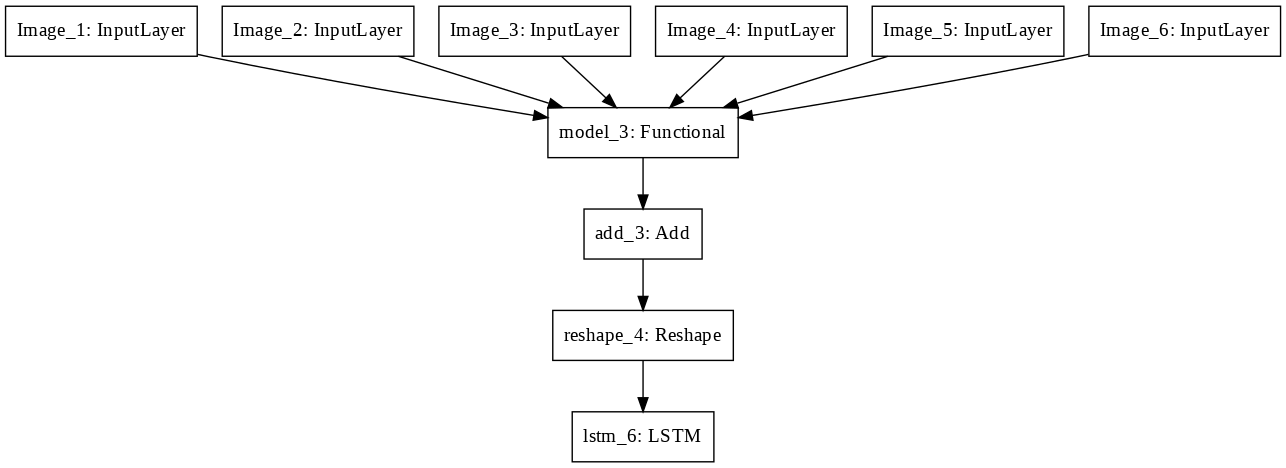

In [ ]:
    tf.keras.utils.plot_model(
        encoder_model, to_file='model1.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=100
    )
    

In [ ]:
#Hidden state input
decoder_state_input_h = tf.keras.layers.Input(shape=(memory_size,))

#Cell state input
decoder_state_input_c = tf.keras.layers.Input(shape=(memory_size,))

#Putting it together
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [ ]:
encoder_outputs = tf.keras.layers.Input(shape=(49, memory_size,))

In [ ]:
#Get Embedding layer output
x = decoder_embedding(decoder_inputs)

#We will use the layer which we trained earlier
rnn_outputs, state_h, state_c = decoder_rnn(x, initial_state=decoder_states_inputs)

#Why do we need this?
decoder_states = [state_h, state_c]

In [ ]:
#Attention score
p_score = tf.keras.layers.dot([rnn_outputs, encoder_outputs], axes=2)

#Perform softmax to get Attention matrix
p_attention_matrix = tf.keras.layers.Activation('softmax')(p_score)

#Context Vector
p_context_vector = tf.keras.layers.dot([p_attention_matrix, encoder_outputs], axes=[2,1])

#Build Attention Vector
# 1. Caoncatenate both context vector and decoder outputs
# 2. Feed it to the Dense layer 
p_context_decoder_hidden = tf.keras.layers.concatenate([p_context_vector, rnn_outputs])
p_attention_vector = attention_dense_layer(p_context_decoder_hidden)

In [ ]:
p_attention_matrix

<KerasTensor: shape=(None, 135, 49) dtype=float32 (created by layer 'activation_6')>

In [ ]:
decoder_outputs = decoder_dense(p_attention_vector)

In [ ]:
#3 Inputs - Word, h/c state and all hidden states from encoder
#3 Outputs - predicted word, h and c state values for next run and alignment matrix for visualization

decoder_model = tf.keras.models.Model([decoder_inputs] +  #Start sequence and then word
                                      decoder_states_inputs + #h and c state value for initialization
                                      [encoder_outputs],  #Encoder all hidden states for Attention layer
                                      [decoder_outputs] + #Model word prediction
                                      decoder_states +   #h and c states for next run
                                      [p_attention_matrix]) #for Alignment matrix

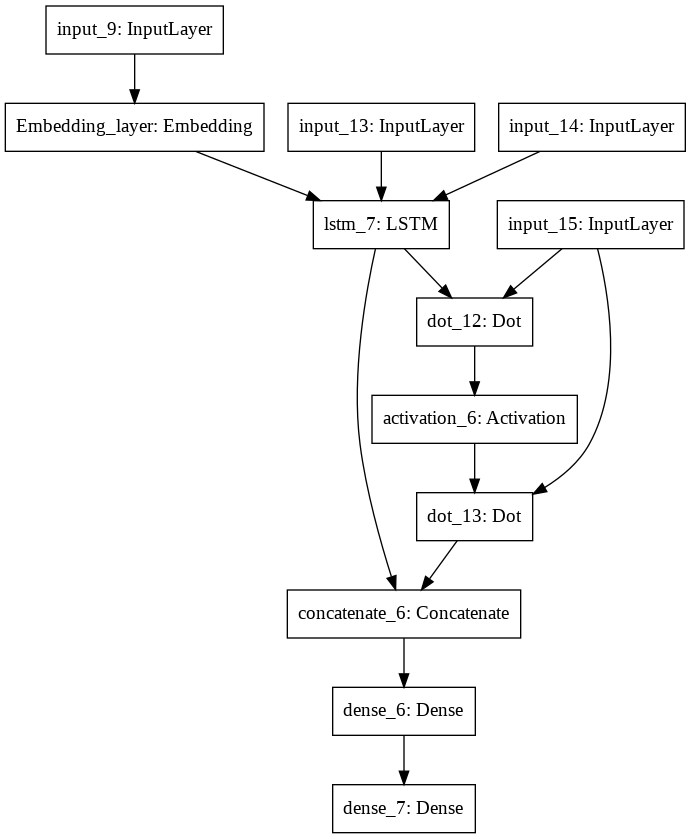

In [ ]:
    tf.keras.utils.plot_model(
        decoder_model, to_file='model1.png', show_shapes=False, show_dtype=False,
        show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
    )
    

In [ ]:
X1=tf.convert_to_tensor(x1)
X2=tf.convert_to_tensor(x2)
X3=tf.convert_to_tensor(x3)
X4=tf.convert_to_tensor(x4)
X5=tf.convert_to_tensor(x5)
X6=tf.convert_to_tensor(x6)


In [ ]:
(FM_T1_TSE_TRA[5]!=FM_T1_TSE_TRA[2]).sum() #149694

0

In [ ]:
def caption_image(image):
    
    #Load image and make it a batch of 1
    #img = tf.keras.preprocessing.image.load_img(image_file, target_size=(img_size, img_size))
    #img_array = tf.keras.preprocessing.image.img_to_array(img)
    #img_array = np.expand_dims(img_array, axis=0)
     
    #Normalize image
    #img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    
    inpu1 = FM_T1_TSE_TRA[image]
    #print(inpu1.shape)
    inpu2 = FM_T2_TSE_TRA[image]
    inpu3 = FM_T1_TSE_SAG[image]
    inpu4 = FM_T2_TSE_SAG[image]
    inpu5 = FM_POSDISP_[image]
    inpu6 = FM_LOCALIZER_[image]
    #Get the encoder state values
    encoder_output =  encoder_model.predict([inpu1,inpu2,inpu3,inpu4,inpu5,inpu6])
    decoder_initial_states_value = encoder_output[1:]    
    encoded_seqs = encoder_output[0]
    
    #Build a sequence with '<start>' - starting sequence for Decoder
    target_seq = np.zeros((1,1))    
    target_seq[0][0] = decoder_t.word_index['startseq']
    
    #flag to check if prediction should be stopped
    stop_loop = False
    
    #Initialize predicted sentence
    predicted_sentence = ''
    
    #start the loop
    while not stop_loop:
        
        #Decoder model with 3 inputs
        predicted_outputs, h, c, a_matrix = decoder_model.predict([target_seq] + 
                                                                  decoder_initial_states_value +
                                                                  [encoded_seqs])
        
        #Get the predicted word index with highest probability
        predicted_output = np.argmax(predicted_outputs[0,-1,:])
        
        #Get the predicted word from predicter index
        if (predicted_output == 0):
            predicted_word = ' '
        else:
            predicted_word = int_to_word_decoder[predicted_output]
        
        #Check if prediction should stop
        if(predicted_word == 'endseq' or len(predicted_sentence) > max_decoder_seq_length):
            
            stop_loop = True
            continue
                    
        #Updated predicted sentence
        if (len(predicted_sentence) == 0):
            predicted_sentence = predicted_word
        else:
            predicted_sentence = predicted_sentence + ' ' + predicted_word
            
        #Update target_seq to be the predicted word index
        target_seq[0][0] = predicted_output
        
        #Update initial states value for decoder
        decoder_initial_states_value = [h,c]
        
        #print(a_matrix[0][0])
    
    return predicted_sentence

In [ ]:
caption_image(12)

'features of muscle spasm noted. diffuse disc bulge noted at l4-l5 level mildly compressing the thecal sac and exit nerve root.'

In [ ]:
train.Notes.iloc[12]

'startseq l4-l5 broad based central and left paracentral disc protrusion is noted compressing the thecal sac and narrowing left neural foramen. l5-s1: broad based degenerative central disc bulge is noted indenting thecal sac but not causing significant nerve root compression or foraminal narrowing. dehydrated l4-l5 and l5-s1 intervetrebral discs. vertebral bone marrow signal reconversion is noted. endseq'

In [ ]:
len(train)

505

In [ ]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

In [ ]:
train.index[10]

10

In [ ]:
X_train_img.shape[0]

450

In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for i in tqdm(range(X_cv_img.shape[0])):
    
    rep = rem_fullstops(y_cv_rep[i])
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = caption_image(X_cv_img[i])
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

100%|██████████| 50/50 [01:12<00:00,  1.45s/it]


In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_cv_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_cv_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_cv_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_cv_img.shape[0])

Bleu1 Score:  0.3896800830074482
Bleu2 Score:  0.31386956423373996
Bleu3 Score:  0.317468786764796
Bleu4 Score:  0.31055638044444267


In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for i in tqdm(range(X_train_img.shape[0])):
    
    rep = rem_fullstops(y_train_rep[i])
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = caption_image(X_train_img[i])
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

100%|██████████| 450/450 [10:50<00:00,  1.45s/it]


In [ ]:
print('Bleu1 Score: ', sum(bleu1)/X_train_img.shape[0])
print('Bleu2 Score: ', sum(bleu2)/X_train_img.shape[0])
print('Bleu3 Score: ', sum(bleu3)/X_train_img.shape[0])
print('Bleu4 Score: ', sum(bleu4)/X_train_img.shape[0])

Bleu1 Score:  0.400760853702104
Bleu2 Score:  0.32534107128683515
Bleu3 Score:  0.29902517398184075
Bleu4 Score:  0.27938731931514554


In [ ]:
for i in range(len(train)):
  print(i)
  print(caption_image(i))
